# Introduction

This notebook is a quick starter guide on Uproot, Awkward Array, and Vector, which are all Python packages that are part of the Scikit-HEP project. We'll briefly go through parts of each and see how they work together.

Most of this notebook is adapted from my [Uproot tutorial](https://hsf-training.github.io/hsf-training-uproot-webpage/index.html) aimed at beginners in data analysis in Python. Here, I'm assuming that the reader is already familiar with at least Python, NumPy, and Matplotlib, so I've compressed the tutorial and added a bit of more advanced material, but it still just scratches the surface of these packages. See the links at the end for more extensive resources.

## Motivation

### Python

For quite a while now, ROOT has been the main software used by particle physicists for data analysis. ROOT is written in C++, and at least until recently most analysis code has also been written in C++. Outside of HEP, Python is a more commonly used language for data analysis, which means that there are many popular and well-supported tools that can be utilized for common tasks. Python is also generally considered easier to learn than C++.

### Uproot

Uproot is a Python module that can read and write files in the ROOT format. It’s part of the Scikit-HEP project, a collection of Python tools for HEP data analysis. Uproot isn’t the only way to read/write ROOT files in Python; there are other packages that allow you to do this. However, there are some significant advantages of Uproot. We’ll go through a few here.

The only software required by Uproot (other than Python itself, of course) is NumPy. NumPy is by far the most popular Python package for handling arrays of data. It’s included in the Anaconda distribution by default, and in general most people using Python for any kind of data analysis will probably already have it installed. Awkward Array and Vector are not required but highly recommended for use with Uproot. Uproot, Awkward Array, and Vector are all part of the Scikit-HEP project. All of the above are Python modules, which can be installed with nothing more than pip or conda.

Most importantly, Uproot does not require any part of the ROOT software, which is quite large and can be non-trivial to install properly.

Uproot was designed for efficient reading of files. It uses compiled functions with vector optimizations to perform very fast calculations on arrays.

When you import a Python package that uses ROOT, there can be a delay of several seconds while all of the required libraries are loaded. This is required every time you restart the Python interpreter or run a script. By virtue of not using ROOT itself, Uproot doesn’t have this issue.

### Awkward

One issue with manipulating HEP data in Python is that it is often not rectangular. That is, the length of object collections is not constant. For example, different events will have different numbers of jets, and different jets will have different numbers of associated tracks. Such arrays are called jagged arrays. Packages like NumPy are only designed to work with rectangular arrays, where each dimension has a fixed length throughout the entire array.

> Jagged vs. rectangular arrays
>
> The name “jagged array” comes from the idea that if you have a 2D array in which there’s a different number of entries in each row and you line rows up by their first element, then the right edge of the array will be “jagged” as opposed to straight:
>
> Rectangular array:
>
> ```
> [[0, 1],
>  [2, 3],
>  [4, 5],
>  [6, 7],
>  [8, 9]]
> ```
>
> Jagged array:
>
> ```
> [[0, 1],
>  [2, 3, 4],
>  [5],
>  [6, 7],
>  [8, 9]]
> ```

Awkward Array is a package used to deal with jagged arrays so that they can be manipulated in ways almost identical to standard rectangular NumPy arrays. Other Python packages for reading ROOT files usually do not support jagged arrays, which means that you cannot do operations on multiple events at once if you have jagged data. But Uproot and Awkward Array can, and this is generally much faster than operating on one event at a time.

### Vector

Vector is a package that provides an interface for 2D, 3D, and (3+1)D vectors and can be used with NumPy and Awkward Array to perform operations on arrays of vectors. This includes calculations for quantities like invariant mass or $\Delta R$.

## Goal

In order to learn how to use these packages, we’ll try to do a very short and simple analysis to look for resonances in a dimuon events. The example ROOT file is from CMS open data from proton-proton collisions in 2012. Our first goal is just to get to the data within Uproot, so we need to open the file and navigate to the muon information.

## Setup

### Installation

These packages can be installed in the usual way if they haven't been already:

`pip install uproot awkward vector`

They are also available via `conda install` on the `conda-forge` channel.

### Usage

We'll need NumPy and Matplotlib:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Uproot and Vector are normally imported by their name, and Awkward Array is usually imported as `ak` as an analogy to `numpy as np`:

In [2]:
import uproot
import awkward as ak
import vector

# Inspecting data

## Files

### Opening a file

Now open the ROOT file and assign it to a variable (which I’ve named file here):

In [3]:
file = uproot.open('open-data-example.root')

If you inspect file, you can see that it’s a `ReadOnlyDirectory` object:

In [4]:
file

<ReadOnlyDirectory '/' at 0x7fa0c2463250>

### File contents

Just like any other kind of directory, you can list the contents (of the file). The name of each item in the file is called a key.

In [5]:
file.keys()

['Events;1']

We can see that there is one key: “Events”. This doesn’t tell us what kind of object it refers to, though. ROOT files can contain many different types of objects, including subdirectories. The following function provides a way to inspect the types of each item:

In [6]:
file.classnames()

{'Events;1': 'TTree'}

The output contains pairs of the form `name: type`. Therefore the key `Events` refers to a `TTree` object. This is where all the data in this file is stored. The `;1` refers to the cycle number.

### Accessing contents

Now we want to actually access the object inside the file. You can do this just as you would to get an item in an array:

In [7]:
file['Events']

<TTree 'Events' (6 branches) at 0x7fa0c23cad90>

This expression refers to the actual TTree object, which we will look at next.

## Trees

Trees in ROOT are basically just tables of information. Trees are composed of branches, which are the columns of the table. The rows usually represent events (individual bunch crossings).

First we assign the tree to a variable (named `tree` here):

In [8]:
tree = file['Events']

In order to find out what information is in the tree, we need to know what the branches (columns) are. The term key is used (again) here to refer to the names of the branches.

In [9]:
tree.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

The above output is a list of the branch names. So we can see that for each event, we will have the number of muons in the event (nMuon) and the pT, eta, phi, mass, and charge of each muon.

In [10]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


But how do we get the actual data from the table? There are several ways with Uproot, but the simplest is with the arrays() function:

In [11]:
tree.arrays()

<Array [{nMuon: 2, Muon_pt: [10.8, ... -1, 1]}] type='100000 * {"nMuon": uint32,...'>

You can see some numbers in there, which indeed are from the data in the tree.

## Branches

Now we assign this object (which contains both the names and contents of the branches) to another variable (branches):

In [12]:
branches = tree.arrays()

Next let’s just look at each branch individually. You can access a single branch from branches in a similar way to getting an item from a ROOT file object (array-like notation):

In [13]:
branches['nMuon']

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * uint32'>

You can see the partial list of numbers in the output that represents the number of muons in each event. It’s abbreviated with an ellipsis (...) so that it doesn’t take up the whole page.

These Array objects are a special type provided by the Awkward Array package. The type=100000 * uint32 means that there are 100,000 entries and that each entry is a 32-bit unsigned integer. Each entry corresponds to one event.

Let’s look at another branch:

In [14]:
branches['Muon_pt']

<Array [[10.8, 15.7], ... 11.4, 3.08, 4.97]] type='100000 * var * float32'>

This is a jagged array because the number of entries is different for different events (because each event can have a different number of muons). Note that there are square brackets [] surrounding the list of entries for each event. The type='100000 * var * float32' means that there are 100,000 rows, each containing a variable number of 32-bit floating point numbers. This is basically an array of arrays (or a 2D array).
Events

If we want to focus on a particular event, we can index it just like a normal array:

In [15]:
branches['Muon_pt'][0]

<Array [10.8, 15.7] type='2 * float32'>

From the above output, the first event has two muons, and the two numbers in the list are the muons’ pT. It’s not specified anywhere in the file, but the units are GeV. Let’s look at the third event:

In [16]:
branches['Muon_pt'][2]

<Array [3.28] type='1 * float32'>

It only has one muon.

What if we want to get all of the information about a single event? So far we’ve accessed data in branches by providing a branch name, but we can also just use an event index:

In [17]:
branches[0]

<Record ... 0.106], Muon_charge: [-1, -1]} type='{"nMuon": uint32, "Muon_pt": va...'>

This is a Record object, which is another special type provided by Awkward Array. It functions basically the same way as a standard Python dictionary (dict). Unfortunately, most of the interesting information is still hidden in the above output to save space. A little trick we can use to force printing all the data is adding .tolist():

In [18]:
branches[0].tolist()

{'nMuon': 2,
 'Muon_pt': [10.763696670532227, 15.736522674560547],
 'Muon_eta': [1.0668272972106934, -0.563786506652832],
 'Muon_phi': [-0.03427272289991379, 2.5426154136657715],
 'Muon_mass': [0.10565836727619171, 0.10565836727619171],
 'Muon_charge': [-1, -1]}

There we go. Now we can see the whole picture for an individual event.

`.tolist()` is a NumPy function that has been extended to Awkward Array objects. As the name suggests, it converts NumPy arrays to Python lists. In the case of trees, which have named branches, it actually converts to a dictionary of lists. It can be very useful when you want to understand exactly what’s in an Array or Record. Be careful when using it, though–trying to print out an entire branch or tree could cause Python to crash if it’s large enough. Therefore it’s best to only use `tolist()` on one or a few events at a time to be safe.

If you only want to see a description of the structure of the array and types within it (not the data itself), you can use `.type`:

In [19]:
branches.type

100000 * {"nMuon": uint32, "Muon_pt": var * float32, "Muon_eta": var * float32, "Muon_phi": var * float32, "Muon_mass": var * float32, "Muon_charge": var * int32}

# Transforming data

Uproot is designed for columnar analysis, which means performing operations on entire columns (branches) at a time, rather than operating on every event individually.

## Counting

The simplest task we need for analysis is counting (i.e., cutflow). To count the total number of events, we can use the Python built-in function `len()` on any of the following:

```python
len(branches)
len(branches['nMuon'])
len(branches['Muon_pt']) # or any of the other branches...
```

which will output `100000`. So there are 100,000 events.

For counting the number of entries in each event for a branch, there's `ak.num`:

In [20]:
ak.num(branches['Muon_pt'])

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * int64'>

which in this case is equal to already existing `branches['nMuon']`.

## Selections

### Selections from 1D arrays

To do more interesting counting or plotting, we want to be able to select only events or muons that pass some criteria. Just as you can compare two numbers, like `1 < 2` and get a `True` or `False` value, you can put arrays in comparisons as well. Let’s look at this case:

In [21]:
branches['nMuon'] == 1

<Array [False, False, True, ... False, False] type='100000 * bool'>

This is checking for equality between an array and the number 1. Of course these are different types (array vs. scalar), so the Python objects are certainly not identical, but you can see the return value is not just False. What happens is that each element in the array is compared to the scalar value, and the return value is a new array (of the same shape) filled with all these comparison results. So we can interpret the output as the result of testing whether each event has exactly one muon or not. The first two events do not, the third does, and so on.

This array of Boolean values is called a mask because we can use it to pick out only the elements in the array that satisfy some criteria (like having exactly one muon). This is very useful, and we will save it to a variable to save typing later:

In [22]:
single_muon_mask = branches['nMuon'] == 1

### Counting with selections

Now let’s say we want to know how many of these single-muon events there are. Note that len() won’t work because the length of the array is still 100,000. That is, there’s a value for every event (even if that value is `False`). We need the number of `True`s in the array. There are multiple ways to do this, but my favorite is:

In [23]:
np.sum(single_muon_mask)

13447

`sum()` adds all the array values together. `True` is interpreted as `1` and `False` is interpreted as `0`, thus `sum()` is just the number of True entries. So there are 13,447 events with exactly one muon.

Note that I've used a NumPy function here on an `ak.Array`. Most of the standard NumPy functions work fine on Awkward `Array`s, although there are also equivalent Awkward functions like `ak.sum`. Generally speaking, the default behavior between these NumPy and Awkward functions is the same, but the `ak` versions have optional parameters for funcationality that is specific to jagged arrays. Awkward also has functions that wouldn't make sense in NumPy, such as `ak.num`.

### Applying a mask to an array

If we want to apply some selection to an array (i.e., cut out events or muons that don’t pass), we just act like the selection mask is an index. For example, if we want the pT of only those muons in events with exactly one muon (so they’re the only muon in that event):

In [24]:
branches['Muon_pt'][single_muon_mask]

<Array [[3.28], [3.84], ... [13.3], [9.48]] type='13447 * var * float32'>

We can check that we really are only looking at the events that pass the selection by looking the number of rows:

In [25]:
len(branches['Muon_pt'][single_muon_mask])

13447

Yep, this matches the counting from single_muon_mask.sum() above.
Plotting with selections

We can also use masks to plot quantities after some selection. For example, let’s plot the muon pT for only the single-muon events:

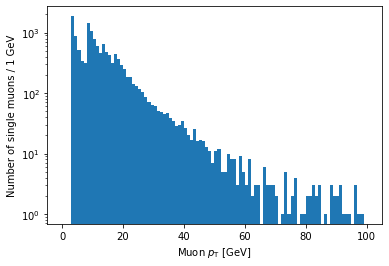

In [26]:
plt.hist(ak.flatten(branches['Muon_pt'][single_muon_mask]), bins=100, range=(0, 100))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 1 GeV')
plt.yscale('log')
plt.show()

If you’re looking carefully, you might notice that this plot is missing the hump around 45 GeV that was in the pT plot before (for all muons). We accidentally ran into a hint of an effect from real physics. Neat!
Selections from a jagged array

Let’s look at a comparison for a jagged array, using the absolute value of muon eta:

In [27]:
eta_mask = abs(branches['Muon_eta']) < 2
eta_mask

<Array [[True, True], ... True, True, True]] type='100000 * var * bool'>

Again, the mask array has the same dimensions as the original array. There’s one Boolean value for each muon, corresponding to whether its eta is less than 2 in absolute value.
Counting

We can do counting and plotting just as before:

In [28]:
np.sum(eta_mask)

204564

This is the number of muons that pass the eta cut.

### Plotting

Let’s plot both the original eta distribution and the one after the cut to verify its effect:

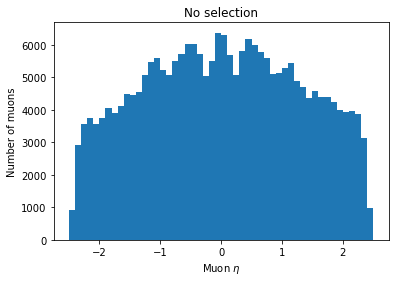

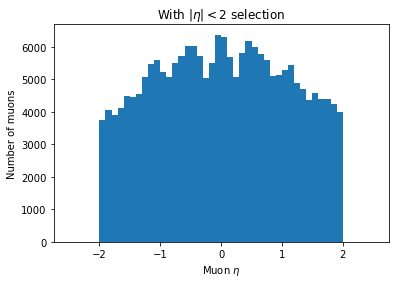

In [29]:
plt.hist(ak.flatten(branches['Muon_eta']), bins=50, range=(-2.5, 2.5))
plt.title('No selection')
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.show()

plt.hist(ak.flatten(branches['Muon_eta'][eta_mask]), bins=50, range=(-2.5, 2.5))
plt.title('With $|\eta| < 2$ selection')
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.show()

You can see the second plot just has both ends past 2 cut off, demonstrating that we’ve cut those muons out.
Operations on selections

We can invert selections with ~ (the NOT operator):

In [30]:
~single_muon_mask

<Array [True, True, False, ... True, True] type='100000 * bool'>

This new mask is False only for events with exactly one muon and True otherwise.

We can get the intersection of selections with & (the AND operator):

In [31]:
single_muon_mask & eta_mask

<Array [[False, False], ... False, False]] type='100000 * var * bool'>

This mask is True only for muons with no other muons in their event and abs(eta) < 2.

Or we can get the union of selections with | (the OR operator):

In [32]:
single_muon_mask | eta_mask

<Array [[True, True], ... True, True, True]] type='100000 * var * bool'>

This mask is True for muons which are the only muon in their event or which have abs(eta) < 2.

### Comparing histograms

Now we can use these operations to compare distributions for different selections. Let’s look at the pT of single-event muons split into two groups by whether or not abs(eta) < 2. All we have to do is provide a list of arrays as the first argument to hist rather than just one array. Note the square brackets around the two arrays:

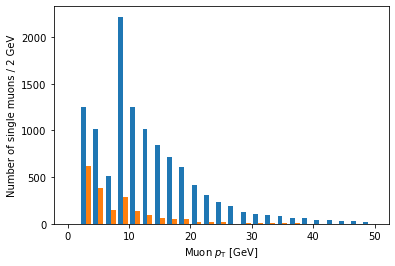

In [33]:
plt.hist([ak.flatten(branches['Muon_pt'][single_muon_mask & eta_mask]),
          ak.flatten(branches['Muon_pt'][single_muon_mask & ~eta_mask])],
         bins=25, range=(0, 50))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 2 GeV')
plt.show()

Ah, but it doesn’t actually say which histogram is which. For that, we need to add labels and a legend:

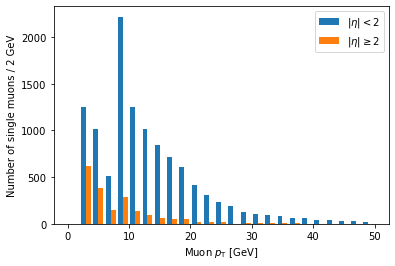

In [34]:
plt.hist([ak.flatten(branches['Muon_pt'][single_muon_mask & eta_mask]),
          ak.flatten(branches['Muon_pt'][single_muon_mask & ~eta_mask])],
         label=['$|\eta| < 2$', '$|\eta| \geq 2$'],
         bins=25, range=(0, 50))
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 2 GeV')
plt.legend()
plt.show()

label is a list of strings passed to hist, corresponding to the arrays (in the same order), and we have to add plt.legend() in order to actually draw a legend with those labels.

Another problem is that these histograms are on different scales because there are fewer large eta muons. Often we want to compare only the shapes of the distribution, so we normalize the integral of each to 1. We can achieve this by adding density=True to the hist() call:

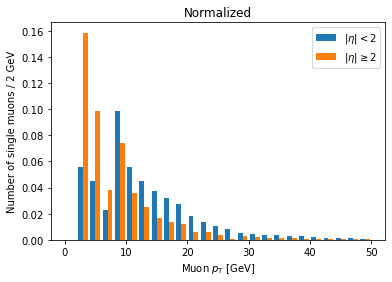

In [35]:
plt.hist([ak.flatten(branches['Muon_pt'][single_muon_mask & eta_mask]),
          ak.flatten(branches['Muon_pt'][single_muon_mask & ~eta_mask])],
         label=['$|\eta| < 2$', '$|\eta| \geq 2$'],
         bins=25, range=(0, 50), density=True)
plt.title('Normalized')
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 2 GeV')
plt.legend()
plt.show()

Now we can clearly see there’s a significantly higher fraction of muons with abs(eta) >= 2 at lower pT compared to muons with abs(eta) < 2. This makes geometric sense, since muons at higher abs(eta) are traveling in a direction less perpendicular to the beam.

(This name of the density parameter refers to the idea of interpreting the histogram as a probability density function, which always has an integral of 1.)

# Analyzing data

Okay, we’re finally ready to look for resonances in dimuon events.

We need a mask that selects events with exactly two muons:

In [36]:
two_muons_mask = branches['nMuon'] == 2

## Vectors

Now we need to construct the four-momenta of each muon. Vector is a package that provides an interface to operate on 2D, 3D, and 4D vectors. We can get the four-momenta of all muons in the tree by using vector.zip and passing it the pT, eta, phi, and mass arrays:

In [37]:
import vector
muon_p4 = vector.zip({'pt': branches['Muon_pt'], 'eta': branches['Muon_eta'], 'phi': branches['Muon_phi'], 'mass': branches['Muon_mass']})

We’ll go ahead and filter out events that don’t contain exactly two muons:

In [38]:
two_muons_p4 = muon_p4[two_muons_mask]

Then let’s take a look at it:

In [39]:
two_muons_p4

<MomentumArray4D [[{rho: 10.8, ... tau: 0.106}]] type='48976 * var * Momentum4D[...'>

This is an array of 4D momenta. We can get the components back out with these properties:

```python
two_muons_p4.pt
two_muons_p4.eta
two_muons_p4.phi
two_muons_p4.E
two_muons_p4.mass
```

What we want is the invariant mass of the two muons in each of these events. To do that, we need the sum of their four-vectors. First, we pick out the first muon in each event with 2D slice:

In [40]:
first_muon_p4 = two_muons_p4[:, 0]

In the notation [:, 0], : means “include every row in the first dimension” (i.e., all events in the array). The comma separates the selection along the first dimension from the selection along the second dimension. The second dimension is the muons in each event, so we want the first, or the one at the 0 index. Then we do the same to get the second muon in each event, just changing the 0 index to 1:

In [41]:
second_muon_p4 = two_muons_p4[:, 1]

    DeltaR

    Another useful feature of these four-vector arrays is being able to compute deltaR (= sqrt(deltaEta^2 + deltaPhi^2)):

    first_muon_p4.deltaR(second_muon_p4)

    plt.hist(first_muon_p4.deltaR(second_muon_p4), bins=100)
    plt.xlabel('$\Delta R$ between muons')
    plt.ylabel('Number of two-muon events')
    plt.show()

    dimuon_delta_r.png

    In principle, we could use this to clean up our invariant mass distribution, but we’ll skip that for simplicity.

Adding the four-vectors of the first muon and the second muon for all events is really as easy as:

In [42]:
sum_p4 = first_muon_p4 + second_muon_p4
sum_p4

<MomentumArray4D [{rho: 8.79, phi: 1.83, ... tau: 16.5}] type='48976 * Momentum4...'>

This is a 1D array of the four-vector sum for each event.

The last thing we need to do before we’re ready to plot the spectrum is to select only pairs with opposite charges:

In [43]:
two_muons_charges = branches['Muon_charge'][two_muons_mask]
opposite_sign_muons_mask = two_muons_charges[:, 0] != two_muons_charges[:, 1]

We apply this selection to the four-vector sums to get the dimuon four-vectors:

In [44]:
dimuon_p4 = sum_p4[opposite_sign_muons_mask]

## Physics

In [45]:
two_muons_charges = branches['Muon_charge'][two_muons_mask]
opposite_sign_muons_mask = two_muons_charges[:, 0] != two_muons_charges[:, 1]

In [46]:
dimuon_p4 = sum_p4[opposite_sign_muons_mask]

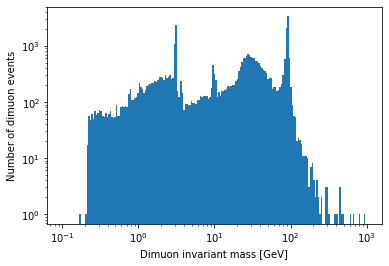

In [47]:
plt.hist(dimuon_p4.mass, bins=np.logspace(np.log10(0.1), np.log10(1000), 200))
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [48]:
len(dimuon_p4)

37183

    Exercise

    Plot a histogram of the dimuon invariant mass on a log-log plot. Try to find all resonances (there are at least 7 visible). How many dimuon events are there?

        Solution

        plt.hist(dimuon_p4.mass, bins=np.logspace(np.log10(0.1), np.log10(1000), 200))
        plt.xlabel('Dimuon invariant mass [GeV]')
        plt.ylabel('Number of dimuon events')
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

        dimuon_invariant_mass_hist_1.png

        Labeled resonances:

        dimuon_invariant_mass_hist_2_labeled.png

        len(dimuon_p4)

        37183

    Key Points

        Vector has allows you to manipulate arrays of four-vectors.

        Uproot can be used to do real physics analyses.

## Multiple files and large files

`uproot.open()` and `tree.arrays()` works fine for looking at one file at a time, but often trees are spread across several ROOT files. There are a few options to deal with this in Uproot.

The simplest is to join all the arrays

`uproot.concatenate({'*.root': 'Events'})`

Another method is to iterate through the entries across all files:

```python
for events in uproot.iterate({'*.root': 'Events'}, step_size=100):
    # do something with events
```
In each iteration of the loop, `events` is a 100-row chunk of the full tree. This avoids loading all entries at the same time. This is important if the files are too large to fit into memory.

There are also some other techniques to reduce the memory usage. If you are only interested in looking at a few events, you can do:

In [49]:
tree.arrays(entry_stop=100)

<Array [{nMuon: 2, Muon_pt: [10.8, ... 1, -1]}] type='100 * {"nMuon": uint32, "M...'>

If you only need a subset of the branches from the tree, you can load each branch into an array individually, like:

In [50]:
tree['nMuon'].array()

<Array [2, 2, 1, 4, 4, 3, ... 0, 3, 2, 3, 2, 3] type='100000 * uint32'>

or you can provide a list of branch names to `arrays` to get only those branches:

In [51]:
tree.arrays(['Muon_pt', 'Muon_eta'])

<Array [{Muon_pt: [10.8, 15.7, ... 0.764]}] type='100000 * {"Muon_pt": var * flo...'>

My preference is to use `uproot.lazy()`:

In [52]:
lazy_branches = uproot.lazy({'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root': 'Events'})

# Creating new objects and files

So far, we've seen how Uproot, Awkward, and Vector can be used to read and manipulate data from already existing ROOT files. In this section we'll look at how these packages can also be used to construct new objects and write data to files.

## Arrays

New `Arrays` can be easily be created like NumPy's `np.array`

In [53]:
ak.Array([[1],
          [2, 3],
          [],
          [4]])

<Array [[1], [2, 3], [], [4]] type='4 * var * int64'>

## Vectors

Individual vectors can be created with `vector.obj`:

In [54]:
vector.obj(pt=1, eta=1, phi=1, e=2)

vector.obj(pt=1, phi=1, eta=1, E=2)

And we've already seen how to make arrays of vectors:

In [55]:
vector.zip({'pt': ak.Array([1]),
            'eta': ak.Array([1]),
            'phi': ak.Array([1]),
            'e': ak.Array([2])})

<MomentumArray4D [{rho: 1, phi: 1, eta: 1, t: 2}] type='1 * Momentum4D["rho": in...'>

## Files

To write to a ROOT file, use `uproot.create()`, `uproot.recreate()`, or `uproot.update()`, which correspond to the same modes as in the `option` parameter of ROOT's `TFile.Open()`. For example, to create or replace `new_file.root`:

In [56]:
uproot.recreate('new_file.root')

<WritableDirectory '/' at 0x7fa0b406b2e0>

Writable file objects allow an assignment syntax for new elements, similar to a dictionary:
```
file['new_object_name'] = new_object
```

## Trees

Trees can be specified by an `Array` or a dictionary of arrays:

In [57]:
with uproot.update('new_file.root') as new_file:
    new_file['new_tree'] = {'branch1': ak.Array([1]), 'branch2': ak.Array([2])}

In [58]:
uproot.open('new_file.root')['new_tree'].arrays()

<Array [{branch1: 1, branch2: 2}] type='1 * {"branch1": int64, "branch2": int64}'>

## Histograms

Histograms from NumPy (or Hist) can be interpreted into ROOT's `TH1`:

In [59]:
array = np.random.random(1000)
numpy_histogram = np.histogram(array, bins=50, range=(0, 1))
numpy_histogram

(array([20, 22, 27, 21, 18, 17, 18, 26, 22, 22, 27, 19, 17, 19, 17, 20, 24,
        21, 17, 18, 25, 15, 17, 17, 17, 18, 26, 19, 20, 12, 23, 14, 24, 12,
        17, 23, 22, 21, 16, 19, 29, 20, 21, 28, 23, 13, 20, 21, 17, 19]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

In [60]:
with uproot.update('new_file.root') as new_file:
    new_file['new_histogram'] = numpy_histogram

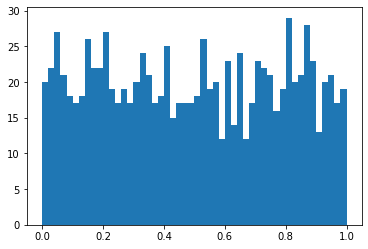

In [61]:
hist, bin_edges = uproot.open('new_file.root')['new_histogram'].to_numpy()
plt.stairs(hist, bin_edges, fill=True)
plt.show()

# Wrap up

# Links to more resources

- Uproot
    - [GitHub repository](https://github.com/scikit-hep/uproot4)
    - [Documentation](https://uproot.readthedocs.io/en/latest/)
- Awkward
    - [GitHub repository](https://github.com/scikit-hep/awkward-1.0)
        - Contains several links to other presentations/tutorials
    - [Documentation](https://awkward-array.org/quickstart.html)
- Vector
    - [GitHub repository](https://github.com/scikit-hep/vector)
    - [Documentation](https://vector.readthedocs.io/en/latest/)